In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.autonotebook import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt

import utils as ut

plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

%load_ext autoreload
%autoreload 2

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_56604/198242598.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Synthetic data: Convolutional model vs GLM

## 1. Make synthetic data

In [142]:
filename = "SSTindivsomata_GLM"
# filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

animal = 'animal_1'
velocity = factors_dict[animal]['Velocity']

activity, place_field, velocity_component, noise = ut.get_synthetic_data(activity_dict, velocity, 
                                                                        place_field_type='positive_ramp', place_field_scale=-1, place_field_shift=-10, 
                                                                        velocity_weight_type='flat', velocity_weight=1, velocity_power=1, 
                                                                        noise_scale=0)

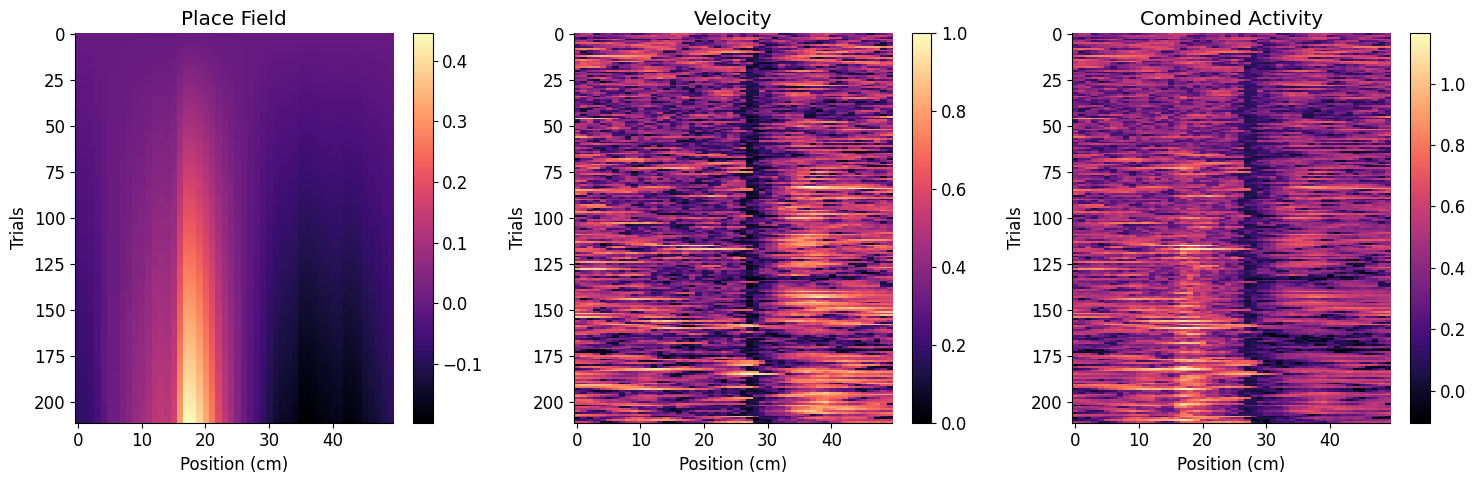

In [143]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

im = ax[0].imshow(place_field.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_title('Place Field')
ax[0].set_xlabel('Position (cm)')
ax[0].set_ylabel('Trials')

im = ax[1].imshow(velocity.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_title('Velocity')
ax[1].set_xlabel('Position (cm)')
ax[1].set_ylabel('Trials')

im = ax[2].imshow(activity.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[2])
ax[2].set_title('Combined Activity')
ax[2].set_xlabel('Position (cm)')
ax[2].set_ylabel('Trials')
plt.tight_layout()
plt.show()

## 2. Train models

100%|██████████| 10000/10000 [00:05<00:00, 1799.61it/s]


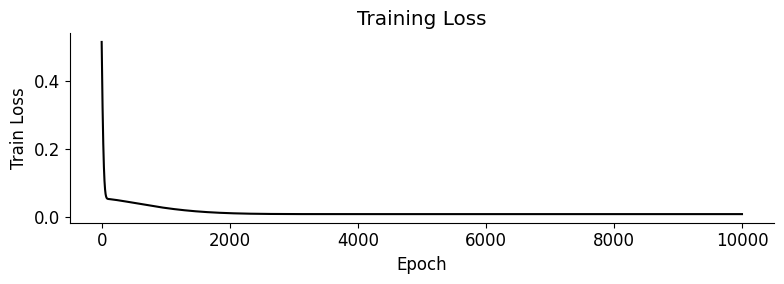

Text(0.5, 1.0, 'Convolutional Kernel')

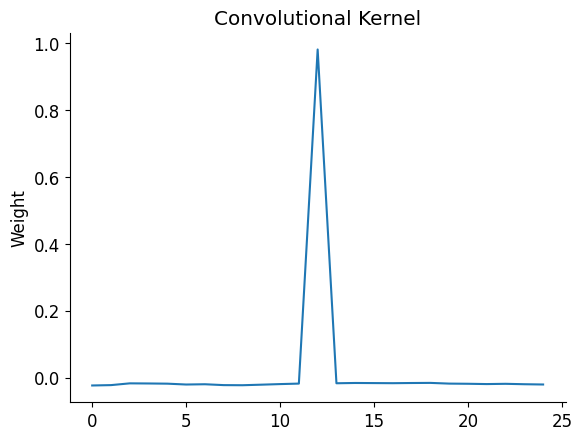

In [102]:
# Train simple convolutional model
model = ut.ConvModel1D(kernel_size=25)
activity_pred = model.fit(velocity, activity, learning_rate=0.001, num_iterations=10_000, plot=True)
conv_prediction = activity_pred.reshape(velocity.shape)

plt.plot(model.conv1.weight.data[0,0])
plt.ylabel('Weight')
plt.title('Convolutional Kernel')

In [103]:
# Train GLM for comparison
filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])
GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity, regression='linear')
GLM_prediction = neuron_predicted_activity.reshape(activity.shape)

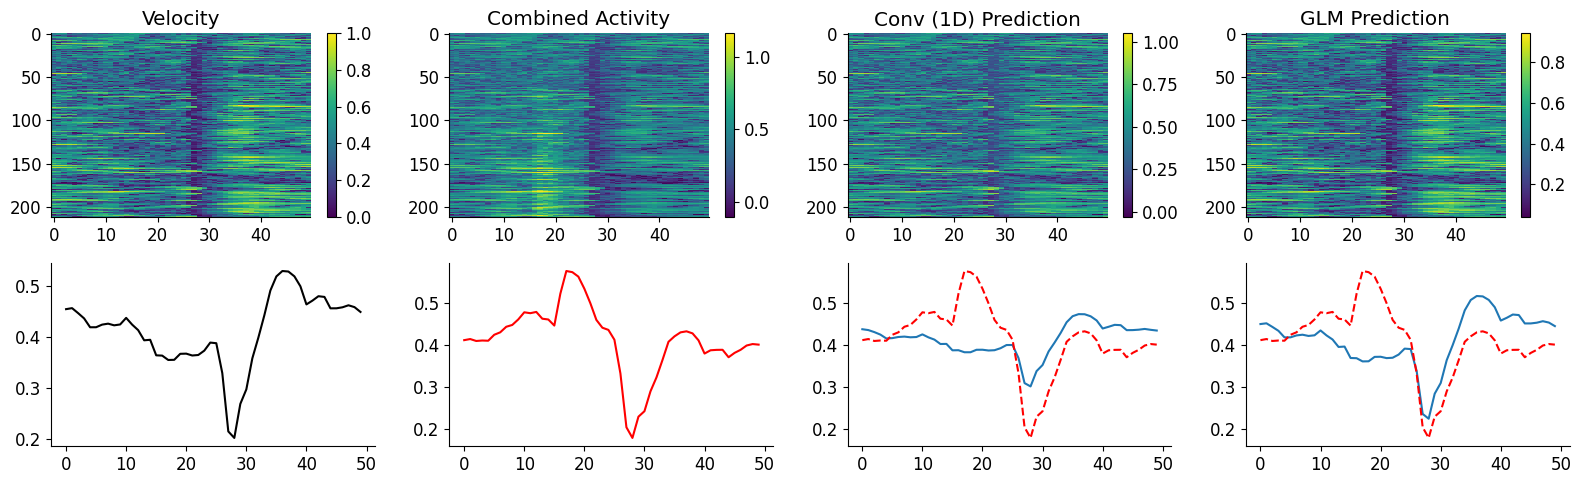

Convolutional Fit MSE: 0.0087
GLM Fit MSE: 0.0100
Convolutional model is a better fit.


In [107]:

fig, ax = plt.subplots(2,4, figsize=(16,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
ax[1,0].plot(velocity.mean(axis=1), 'k')

im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Combined Activity')
ax[1,1].plot(activity.mean(axis=1), 'r')

im = ax[0,2].imshow(conv_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,2])
ax[0,2].set_title('Conv (1D) Prediction')
ax[1,2].plot(conv_prediction.mean(axis=1))
ax[1,2].plot(activity.mean(axis=1), '--r')

im = ax[0,3].imshow(GLM_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,3])
ax[0,3].set_title('GLM Prediction')
ax[1,3].plot(GLM_prediction.mean(axis=1))
ax[1,3].plot(activity.mean(axis=1), '--r')

plt.tight_layout()
plt.show()

conv_residual = activity - conv_prediction
conv_fit_MSE = np.mean(conv_residual**2)
glm_residual = activity - GLM_prediction
glm_fit_MSE = np.mean(glm_residual**2)
print(f"Convolutional Fit MSE: {conv_fit_MSE:.4f}")
print(f"GLM Fit MSE: {glm_fit_MSE:.4f}")
if conv_fit_MSE < glm_fit_MSE:
    print("Convolutional model is a better fit.")
else:
    print("GLM is a better fit.")

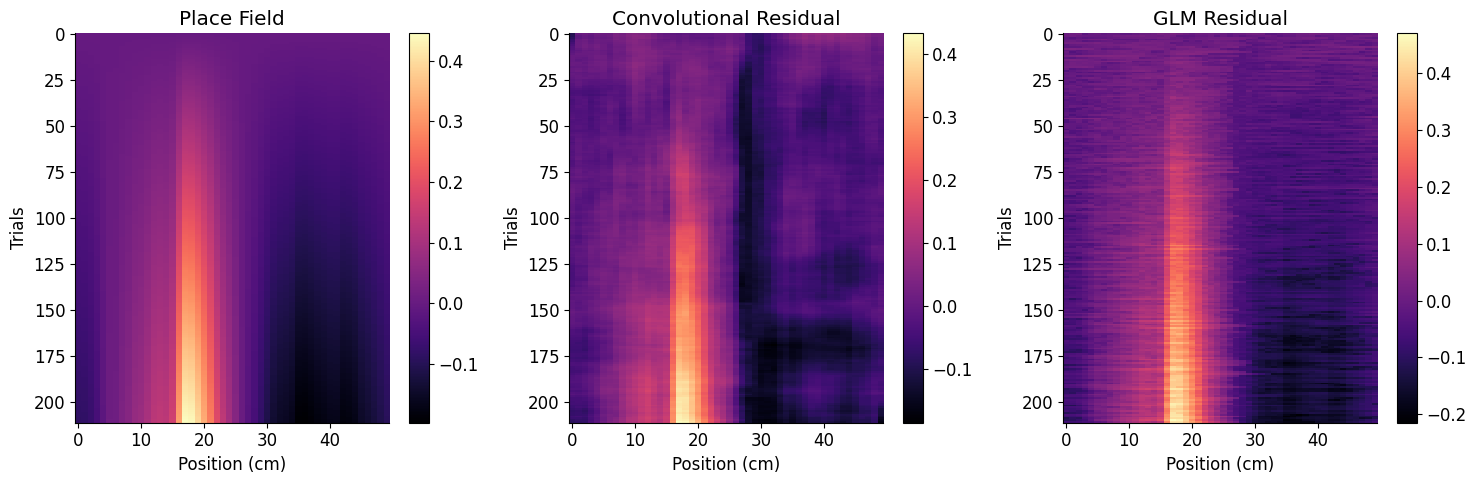

Convolutional Fit vs Ground Truth MSE: 0.0017
GLM Fit vs Ground Truth MSE: 0.0004
GLM is a better fit.


In [105]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

im = ax[0].imshow(place_field.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_title('Place Field')
ax[0].set_xlabel('Position (cm)')
ax[0].set_ylabel('Trials')

im = ax[1].imshow(conv_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_title('Convolutional Residual')
ax[1].set_xlabel('Position (cm)')
ax[1].set_ylabel('Trials')

im = ax[2].imshow(glm_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax[2])
ax[2].set_title('GLM Residual')
ax[2].set_xlabel('Position (cm)')
ax[2].set_ylabel('Trials')

plt.tight_layout()
plt.show()

conv_fit_vs_ground = np.mean((conv_residual - place_field)**2)
glm_fit_vs_ground = np.mean((glm_residual - place_field)**2)
print(f"Convolutional Fit vs Ground Truth MSE: {conv_fit_vs_ground:.4f}")
print(f"GLM Fit vs Ground Truth MSE: {glm_fit_vs_ground:.4f}")
if conv_fit_vs_ground < glm_fit_vs_ground:
    print("Convolutional model is a better fit.")
else:
    print("GLM is a better fit.")

In [106]:
print(GLM_params['weights']['Velocity'], GLM_params['intercept'])

0.9018452112788412 0.040612632546504546


In [100]:
print(torch.max(model.conv1.weight.data), model.conv1.bias.data)

tensor(0.9813) tensor([0.1949])


# Real data: Convolutional model vs GLM

## 1. Load real data

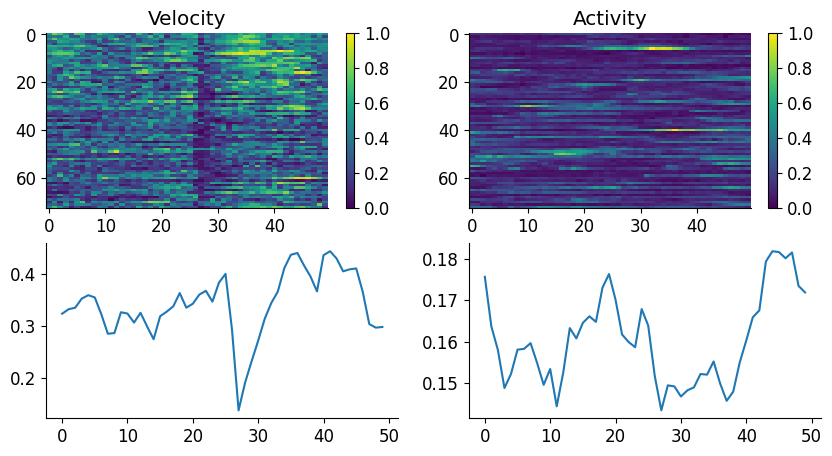

In [156]:
filename = "SSTindivsomata_GLM"
# filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

animal = 'animal_3'
cell = 'cell_4'

velocity = factors_dict[animal]['Velocity']
activity = activity_dict[animal][cell]
activity = (activity - activity.min()) / (activity.max() - activity.min())

fig, ax = plt.subplots(2,2, figsize=(10,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Activity')
ax[1,0].plot(velocity.mean(axis=1))
ax[1,1].plot(activity.mean(axis=1))

## 2. Train models

100%|██████████| 10000/10000 [00:05<00:00, 1982.30it/s]


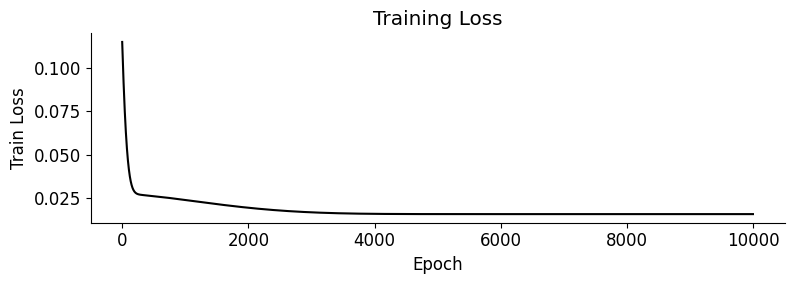

Text(0.5, 1.0, 'Convolutional Kernel')

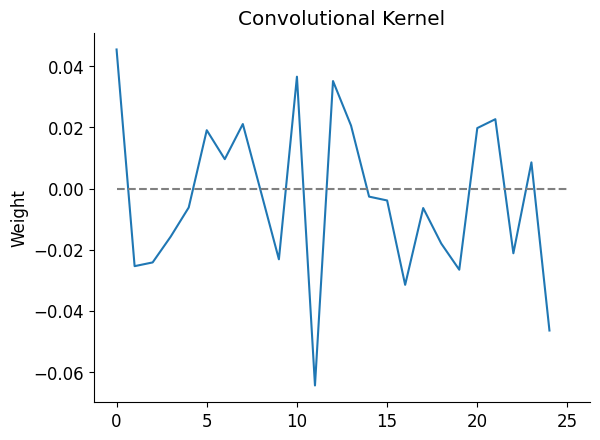

In [157]:
# Train simple convolutional model
kernel_size = 25
model = ut.ConvModel1D(kernel_size=kernel_size)
activity_pred = model.fit(velocity, activity, learning_rate=0.0002, num_iterations=10_000, plot=True)
conv_prediction = activity_pred.reshape(velocity.shape)

plt.plot(model.conv1.weight.data[0,0])
plt.hlines(0,0, kernel_size, color='gray', linestyle='--')
plt.ylabel('Weight')
plt.title('Convolutional Kernel')

In [158]:
# Train GLM for comparison
filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])
GLM_params, neuron_predicted_activity = ut.fit_GLM(filtered_factors_dict[animal], activity, regression='linear')
GLM_prediction = neuron_predicted_activity.reshape(activity.shape)

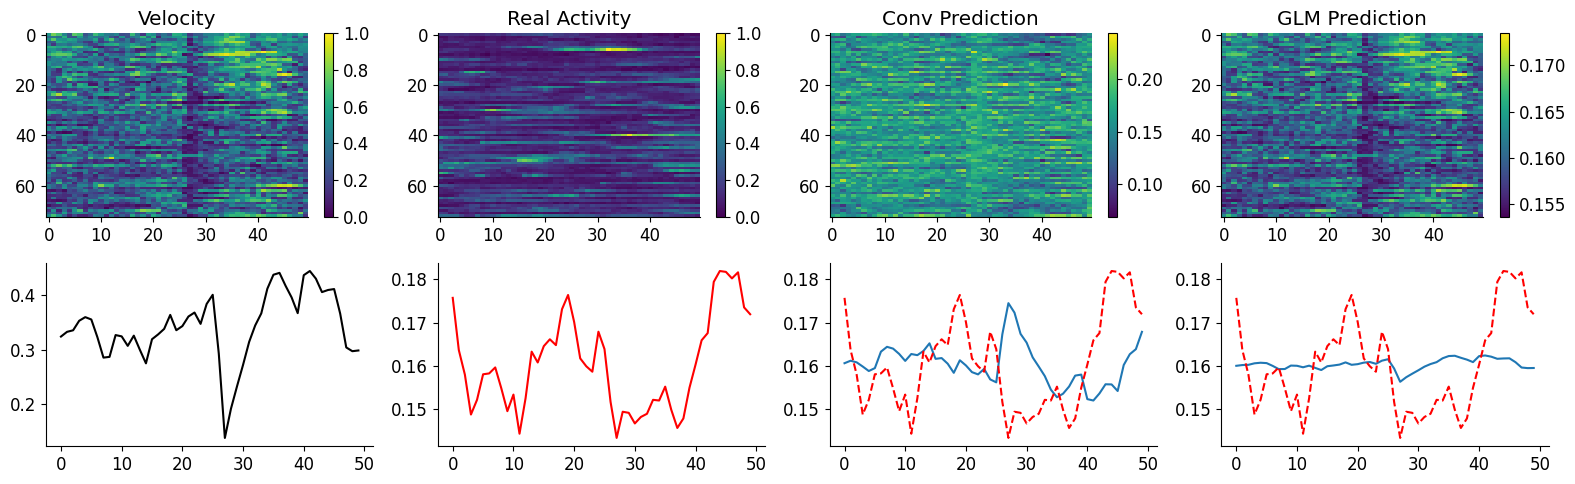

Convolutional Fit MSE: 0.0159
GLM Fit MSE: 0.0166
Convolutional model is a better fit.


In [159]:
fig, ax = plt.subplots(2,4, figsize=(16,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
ax[1,0].plot(velocity.mean(axis=1), 'k')

im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Real Activity')
ax[1,1].plot(activity.mean(axis=1), 'r')

im = ax[0,2].imshow(conv_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,2])
ax[0,2].set_title('Conv Prediction')
ax[1,2].plot(conv_prediction.mean(axis=1))
ax[1,2].plot(activity.mean(axis=1), '--r')

im = ax[0,3].imshow(GLM_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,3])
ax[0,3].set_title('GLM Prediction')
ax[1,3].plot(GLM_prediction.mean(axis=1))
ax[1,3].plot(activity.mean(axis=1), '--r')
plt.tight_layout()
plt.show()

conv_residual = activity - conv_prediction
conv_fit_MSE = np.mean(conv_residual**2)
glm_residual = activity - GLM_prediction
glm_fit_MSE = np.mean(glm_residual**2)
print(f"Convolutional Fit MSE: {conv_fit_MSE:.4f}")
print(f"GLM Fit MSE: {glm_fit_MSE:.4f}")
if conv_fit_MSE < glm_fit_MSE:
    print("Convolutional model is a better fit.")
else:
    print("GLM is a better fit.")

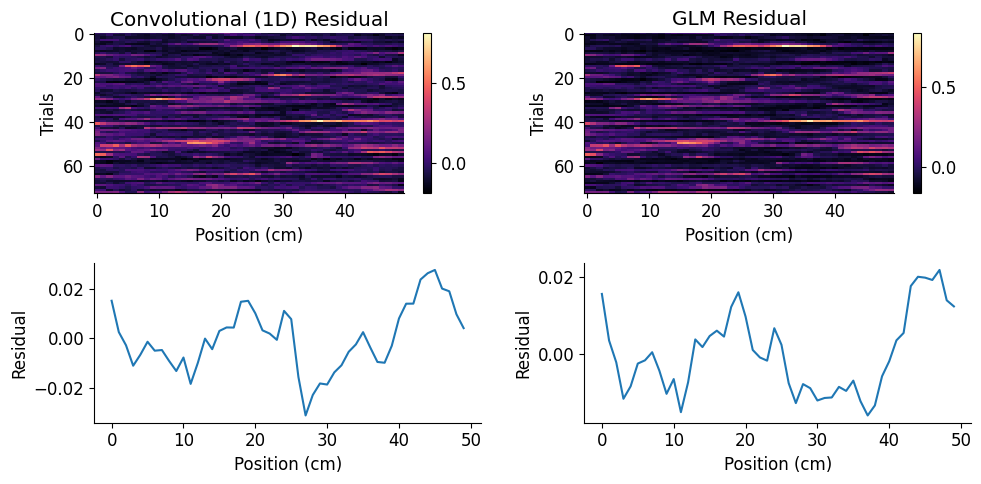

In [160]:
fig, axes = plt.subplots(2,2, figsize=(10,5))

ax = axes[0,0]
im = ax.imshow(conv_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('Convolutional (1D) Residual')
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Trials')
ax = axes[1,0]
ax.plot(conv_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

ax = axes[0,1]
im = ax.imshow(glm_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('GLM Residual')
ax.set_xlabel('Position (cm)')  
ax.set_ylabel('Trials')
ax = axes[1,1]
ax.plot(glm_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

plt.tight_layout()
plt.show()


## 2.1 Train 2D convolutional model

100%|██████████| 10000/10000 [00:34<00:00, 286.45it/s]


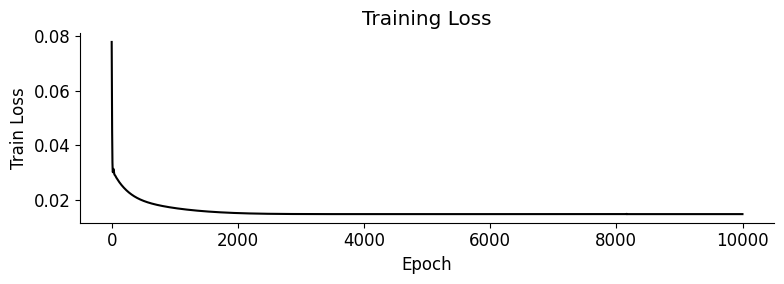

In [161]:
# Train simple convolutional model
kernel_width = 25
kernel_height = 9
model = ut.ConvModel2D(kernel_width=kernel_width, kernel_height=kernel_height)
activity_pred = model.fit(velocity, activity, learning_rate=0.0002, num_iterations=10_000, plot=True)
conv2D_prediction = activity_pred

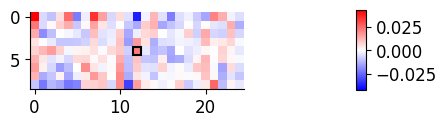

In [162]:
fig, ax = plt.subplots(figsize=(5,1))
color_scale = torch.max(torch.abs(model.conv1.weight.data[0,0]))
im = ax.imshow(model.conv1.weight.data[0,0], aspect='equal', cmap='bwr', vmin=-color_scale, vmax=color_scale)
cax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(im, cax=cax)
box = ax.add_patch(plt.Rectangle((kernel_width/2-1,kernel_height/2-1),1,1,fill=False,edgecolor='k',linewidth=1.5))
plt.show()

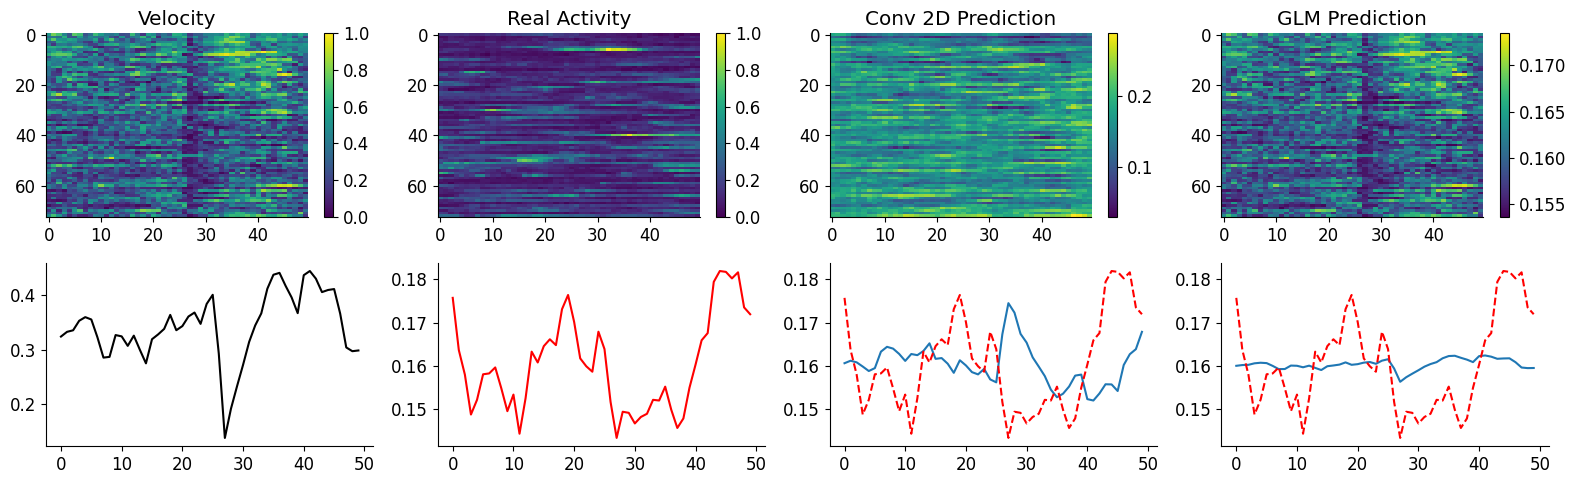

Convolutional (1D) Fit MSE: 0.01594763351641
Convolutional (2D) Fit MSE: 0.01490681628032
GLM Fit MSE: 0.01656
2DConvolutional model is a better fit than GLM.
2DConvolutional model is a better fit than 1DConvolutional model.


In [163]:
fig, ax = plt.subplots(2,4, figsize=(16,5))
im = ax[0,0].imshow(velocity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('Velocity')
ax[1,0].plot(velocity.mean(axis=1), 'k')

im = ax[0,1].imshow(activity.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('Real Activity')
ax[1,1].plot(activity.mean(axis=1), 'r')

im = ax[0,2].imshow(conv2D_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,2])
ax[0,2].set_title('Conv 2D Prediction')
ax[1,2].plot(conv_prediction.mean(axis=1))
ax[1,2].plot(activity.mean(axis=1), '--r')

im = ax[0,3].imshow(GLM_prediction.T, interpolation='nearest', aspect='auto')
cbar = fig.colorbar(im, ax=ax[0,3])
ax[0,3].set_title('GLM Prediction')
ax[1,3].plot(GLM_prediction.mean(axis=1))
ax[1,3].plot(activity.mean(axis=1), '--r')
plt.tight_layout()
plt.show()

conv2D_residual = activity - conv2D_prediction
conv2D_fit_MSE = np.mean(conv2D_residual**2)
glm_residual = activity - GLM_prediction
glm_fit_MSE = np.mean(glm_residual**2)
print(f"Convolutional (1D) Fit MSE: {conv_fit_MSE:.14f}")
print(f"Convolutional (2D) Fit MSE: {conv2D_fit_MSE:.14f}")
print(f"GLM Fit MSE: {glm_fit_MSE:.5f}")
if conv2D_fit_MSE < glm_fit_MSE:
    print("2DConvolutional model is a better fit than GLM.")
    if conv2D_fit_MSE < conv_fit_MSE:
        print("2DConvolutional model is a better fit than 1DConvolutional model.")
else:
    print("GLM is a better fit.")

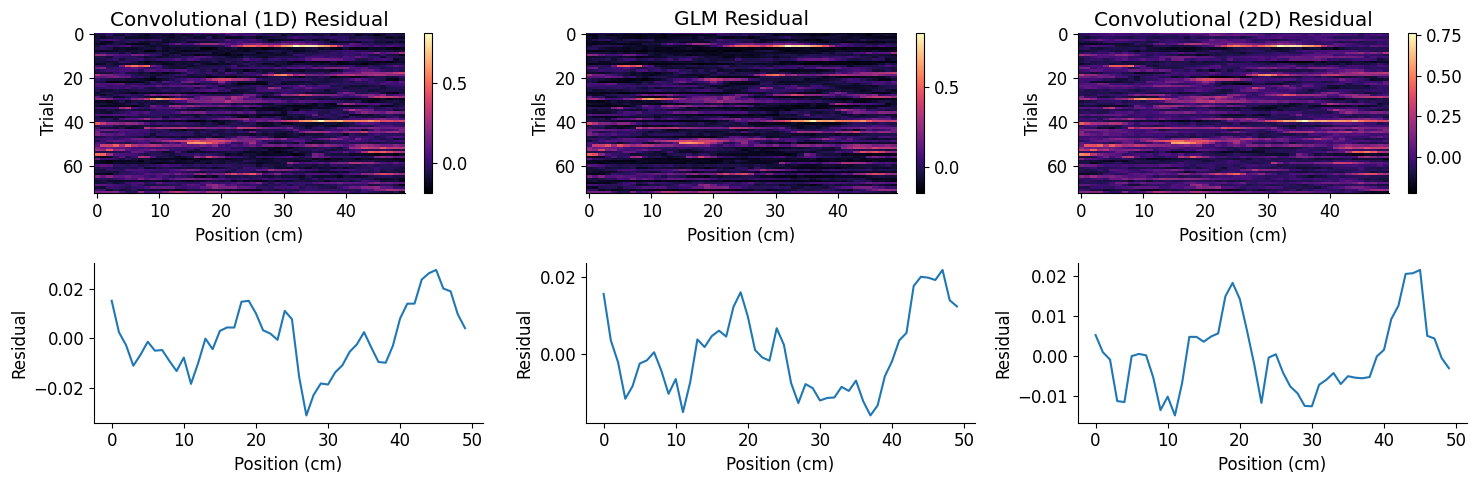

In [164]:
fig, axes = plt.subplots(2,3, figsize=(15,5))

ax = axes[0,0]
im = ax.imshow(conv_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('Convolutional (1D) Residual')
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Trials')
ax = axes[1,0]
ax.plot(conv_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

ax = axes[0,1]
im = ax.imshow(glm_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('GLM Residual')
ax.set_xlabel('Position (cm)')  
ax.set_ylabel('Trials')
ax = axes[1,1]
ax.plot(glm_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

ax = axes[0,2]
im = ax.imshow(conv2D_residual.T, interpolation='nearest', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, ax=ax)
ax.set_title('Convolutional (2D) Residual')
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Trials')
ax = axes[1,2]
ax.plot(conv2D_residual.mean(axis=1))
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Residual')

plt.tight_layout()
plt.show()
